In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**Data Exploration and File matching**

> This cell uses the nibabel library to load NIfTI images and extracts their dimensions. It assumes consistent filenames for images and labels, matching them based on a specified pattern, and prints the dimensions of each matched pair.

> Following this, we have installed the necessary libraries for further model processings

In [2]:
import nibabel as nib
import os

def get_nifti_dimensions(nifti_file):
    img = nib.load(nifti_file)
    return img.shape

image_folder = '/content/gdrive/MyDrive/Task004/imagesTr'
label_folder = '/content/gdrive/MyDrive/Task004/labelsTr'

# Assuming filenames are consistent between images and labels
for image_file in os.listdir(image_folder):
    if image_file.endswith('_0000.nii.gz'):
        label_file = image_file.replace('_0000.nii.gz', '.nii.gz')

        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, label_file)

        image_dims = get_nifti_dimensions(image_path)
        label_dims = get_nifti_dimensions(label_path)

        print(f"Image: {image_file} - Dimensions: {image_dims}")
        print(f"Label: {label_file} - Dimensions: {label_dims}")


Image: 1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_0000.nii.gz - Dimensions: (512, 512, 245)
Label: 1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.nii.gz - Dimensions: (512, 512, 245)
Image: 1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730_0000.nii.gz - Dimensions: (512, 512, 481)
Label: 1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.nii.gz - Dimensions: (512, 512, 481)
Image: 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820_0000.nii.gz - Dimensions: (512, 512, 730)
Label: 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.nii.gz - Dimensions: (512, 512, 730)
Image: 1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_0000.nii.gz - Dimensions: (512, 512, 140)
Label: 1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.nii.gz - Dimensions: (512, 512, 140)
Image: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_0000.nii.gz - Dimensions: (512, 512,

In [3]:
pip install tensorflow

In [4]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00


In [5]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.4 MB/s eta 0:00:00


##**Image Resizing and Visualisation**

> This cell defines a function for resizing images using cropping or padding. It then visualizes a slice from the middle of a pair of images and labels after resizing.

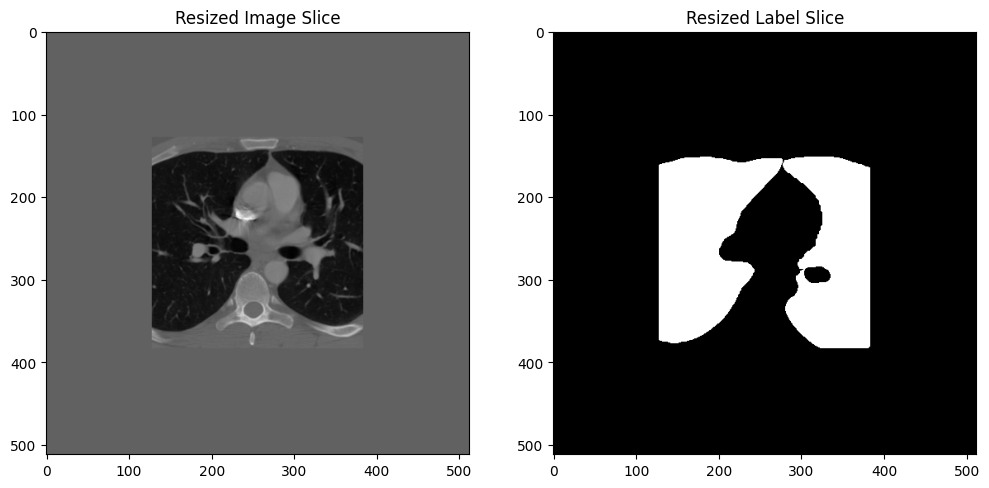

In [6]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def resize_image_with_crop_or_pad(image, img_size=None, **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[tuple(slicer)], to_padding, **kwargs)

def visualize_slice(image, label, slice_index):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image[slice_index], cmap='gray')
    plt.title('Resized Image Slice')

    plt.subplot(1, 2, 2)
    plt.imshow(label[slice_index], cmap='gray')
    plt.title('Resized Label Slice')

    plt.show()

# Set the path to the folders
images_folder = '/content/gdrive/MyDrive/segnetfinal/images1'
labels_folder = '/content/gdrive/MyDrive/segnetfinal/labels1'

# Get the list of files in the folders
image_files = os.listdir(images_folder)
label_files = os.listdir(labels_folder)

# Set the target dimensions
target_dimensions = (512,512,512)

# Assuming you want to visualize only the first pair of image and label
if image_files and label_files:
    image_file = image_files[0]
    label_file = label_files[0]

    # Construct the full paths
    image_path = os.path.join(images_folder, image_file)
    label_path = os.path.join(labels_folder, label_file)

    # Read the image and label
    img_sitk = sitk.ReadImage(image_path, sitk.sitkFloat32)
    mask_sitk = sitk.ReadImage(label_path, sitk.sitkInt32)

    # Convert images to numpy arrays
    image_np = sitk.GetArrayFromImage(img_sitk)
    mask_np = sitk.GetArrayFromImage(mask_sitk)

    # Resize images using crop or pad
    resized_image_np = resize_image_with_crop_or_pad(image_np, img_size=target_dimensions, mode='constant')
    resized_mask_np = resize_image_with_crop_or_pad(mask_np, img_size=target_dimensions, mode='constant')

    # Visualize a slice from the middle of the volumes
    middle_slice_index = target_dimensions[0] // 2
    visualize_slice(resized_image_np, resized_mask_np, middle_slice_index)


##**Data Path Preparation**

> This cell prepares file paths for training and validation by pairing image and label paths. It assumes consistent naming conventions for images and labels and splits the data into training and validation sets based on a specified ratio.

In [7]:
import os

# Directories for images and labels
image_dir = '/content/gdrive/MyDrive/segnetfinal/images1'
label_dir = '/content/gdrive/MyDrive/segnetfinal/labels1'

# Lists to store file paths
train_image_paths = []
train_label_paths = []

# Iterate through the image directory and pair each image with its label
for image_filename in os.listdir(image_dir):
    if image_filename.endswith('_0000.nii.gz'):
        image_path = os.path.join(image_dir, image_filename)

        # Construct the corresponding label's filename and path
        label_filename = image_filename.replace('_0000.nii.gz', '.nii.gz')
        label_path = os.path.join(label_dir, label_filename)

        # Add the paths to the lists
        train_image_paths.append(image_path)
        train_label_paths.append(label_path)

# Zip the image and label paths together
train_images_and_labels = list(zip(train_image_paths, train_label_paths))

# Assuming you'll use some portion of the data for validation
# Split the data into training and validation sets
split_ratio = 0.8  # For example, 80% for training and 20% for validation
split_index = int(len(train_images_and_labels) * split_ratio)

train_files = [{'image': img_path, 'label': label_path} for img_path, label_path in train_images_and_labels[:split_index]]
val_files = [{'image': img_path, 'label': label_path} for img_path, label_path in train_images_and_labels[split_index:]]



##**Data Training and Validation**

> This cell defines data augmentation transforms using the MONAI library.

> It includes operations like intensity scaling, rotation, flipping, noise addition, contrast adjustment, and affine transformations. These transforms are applied to both training and validation datasets.


In [8]:
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
from monai.transforms import (
    Compose, LoadImaged, ScaleIntensityRanged,
    RandRotate90d, RandFlipd, ToTensord,
    RandGaussianNoised, RandAdjustContrastd, RandAffined
)
from monai.data import DataLoader, Dataset
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import Transform

# Custom AddChannel Transform
class AddChannel(Transform):
    def __call__(self, data):
        # Assumes data is a dictionary with 'image' and 'label' keys
        for key in data.keys():
            data[key] = data[key][None]  # Add a channel dimension
        return data

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChannel(),
    ScaleIntensityRanged(keys=["image"], a_min=-1000, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
    RandGaussianNoised(keys=["image"], prob=0.5),
    RandAdjustContrastd(keys=["image"], prob=0.5),
    RandAffined(keys=["image", "label"], mode=('bilinear', 'nearest'), prob=0.5,
                rotate_range=(0, 0, np.pi/15),
                scale_range=(0.1, 0.1, 0.1),
                shear_range=np.pi/6,
                translate_range=(10, 10, 10)),
    ToTensord(keys=["image", "label"])
])

# Validation Transforms
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChannel(),
    ScaleIntensityRanged(keys=["image"], a_min=-1000, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=["image", "label"])
])


##**Model Definition and Configuration**

> This cell defines a 3D U-Net model using the MONAI library.

> It specifies the model's architecture, optimizer (Stochastic Gradient Descent), learning rate scheduler (ReduceLROnPlateau), and loss function (DiceCELoss).

In [9]:
import torch
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjust the U-Net architecture
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # Number of classes
    channels=(32, 64, 128, 256, 512),  # Increased channel numbers
    strides=(2, 2, 2, 2),  # Strides remain the same
    num_res_units=2,
).to(device)

# Define the optimizer with a lower learning rate
optimizer = SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Adjust the learning rate

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

# Define the loss function
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)


In [10]:
train_ds = Dataset(data=train_files, transform=train_transforms)
from monai.data import pad_list_data_collate

# Update your DataLoaders to use the custom collate function
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=pad_list_data_collate)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=pad_list_data_collate)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##**Training Loop and checking accuracy along with Dice Score**

> This cell contains the main training loop. It iterates through epochs, performs training and validation, and saves the best model based on the Dice metric. The learning rate is adjusted using the scheduler. Early stopping is implemented to prevent overfitting.

In [11]:
import time

num_epochs = 20  # Adjust as needed
best_metric = -1
best_metric_epoch = -1
max_no_improvement_epochs = 5
no_improvement_epochs = 0

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for the epoch

    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_epoch_loss = 0
    for batch_data in train_loader:
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    train_epoch_loss /= len(train_loader)

    epoch_duration = time.time() - epoch_start_time  # Calculate the duration for the epoch
    print(f"Average training loss: {train_epoch_loss:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")

    # Validation phase
    model.eval()
    val_dice_metric = DiceMetric(include_background=False, reduction="mean")
    val_loss=0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_outputs = sliding_window_inference(val_inputs, (128, 128, 64), 4, model)
            val_dice_metric(y_pred=val_outputs, y=val_labels)
        metric = val_dice_metric.aggregate().item()
        val_dice_metric.reset()
        print(f"Current mean dice: {metric:.4f}")

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            no_improvement_epochs = 0  # Reset counter
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_metric': best_metric,
            }
            torch.save(checkpoint, 'checkpoint_best_model.pth')
            print(f"Best model saved with mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")
        else:
            no_improvement_epochs += 1
            print(f"No improvement in mean dice for {no_improvement_epochs} consecutive epochs.")

        scheduler.step(val_loss)

Epoch 1/20
Average training loss: 1.3085
Epoch duration: 150.18 seconds
Current mean dice: 0.6031
Best model saved with mean dice: 0.6031 at epoch 1
Epoch 2/20
Average training loss: 1.0843
Epoch duration: 137.25 seconds
Current mean dice: 0.6031
No improvement in mean dice for 1 consecutive epochs.
Epoch 3/20
Average training loss: 0.9507
Epoch duration: 133.27 seconds
Current mean dice: 0.6031
No improvement in mean dice for 2 consecutive epochs.
Epoch 4/20
Average training loss: 0.8610
Epoch duration: 159.65 seconds
Current mean dice: 0.6031
No improvement in mean dice for 3 consecutive epochs.
Epoch 5/20
Average training loss: 0.8038
Epoch duration: 147.13 seconds
Current mean dice: 0.6031
No improvement in mean dice for 4 consecutive epochs.
Epoch 6/20
Average training loss: 0.7583
Epoch duration: 179.08 seconds
Current mean dice: 0.6031
No improvement in mean dice for 5 consecutive epochs.
Epoch 7/20
Average training loss: 0.7582
Epoch duration: 139.72 seconds
Current mean dice: 